In [1]:
using Distributions, DistributionsAD, Plots, StatsPlots, LinearAlgebra, KernelFunctions, BlockDiagonals, MLDatasets, Zygote, LinearAlgebra

In [2]:
import Base.+, Base.-, Base.*
using Flux


struct Gaussian
    μ
    Σ
end
Flux.@functor Gaussian


+(x::Gaussian, y::Gaussian) = Gaussian(x.μ .+ y.μ, x.Σ .+ y.Σ)
+(x::Gaussian, y::Vector) = Gaussian(x.μ .+ y, x.Σ)
+(x::Vector, y::Gaussian) = Gaussian(x .+ y.μ, y.Σ)

-(x::Gaussian, y::Gaussian) = Gaussian(x.μ .- y.μ, x.Σ .+ y.Σ)
-(x::Gaussian, y::Vector) = Gaussian(x.μ .- y, x.Σ)
-(x::Vector, y::Gaussian) = Gaussian(x .- y.μ, y.Σ)

*(x::Matrix, y::Gaussian) = Gaussian(x*y.μ, (x)*y.Σ*transpose(x))
        
*(x::Gaussian, y::Real) = Gaussian(y.*x.μ, y^2 .*x.Σ)
*(x::Real, y::Gaussian) = Gaussian(x.*y.μ, x^2 .*y.Σ)

Gaussian(m::Gaussian, S) = Gaussian(m.μ, S.+m.Σ)
Distributions.MvNormal(m::Gaussian) = Distributions.MvNormal(m.μ, Matrix(Hermitian(m.Σ.+Diagonal(ones(length(m.μ)).*1e-6))))

In [3]:
mutable struct SEKernel <: KernelFunctions.Kernel
     
    se_variance
    se_lengthscale

end

Flux.@functor SEKernel


SEKernel() = SEKernel(zeros(1,1), zeros(1,1))


function KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix,y::Matrix)

    diffed = sum((Flux.unsqueeze(x,3) .- Flux.unsqueeze(y,2)).^2,dims=1)[1,:,:]
    
    return exp(m.se_variance[1,1]) .* exp.(- 0.5 *exp(m.se_lengthscale[1,1]) .* diffed)

end

KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix) = KernelFunctions.kernelmatrix(m,x,x)


function crossderivativekernel(m::SEKernel,x::Matrix,y::Matrix,i=1)

    diffed = (Flux.unsqueeze(x[i:i,:],3) .- Flux.unsqueeze(y[i:i,:],2))[1,:,:]
    kern = kernelmatrix(m,x,y)
    
    result =  exp(m.se_lengthscale[1,1]) .* diffed .* kern
    
    return result
    
end


crossderivativekernel(m::SEKernel,x::Matrix) = crossderivativekernel(m,x,x)
crossderivativekernel(m::SEKernel,x::Matrix,i::Int) = crossderivativekernel(m,x,x,i)


function doaug(k,n,m)
    
    result = zeros(k,k,n,m,k*n,k*m)
    
    for i in 1:k
        for j in 1:k
            for s in 1:n
                for t in 1:m
                    result[i,j,s,t,((i-1)*n+s),((j-1)*m+t)] = 1.
                end
            end
        end
    end
    
    return result
end
Zygote.@nograd doaug


function derivativekernel(m::SEKernel, x::Matrix, y::Matrix,i=1)
    
    diffed = (Flux.unsqueeze(x[i:i,:],3) .- Flux.unsqueeze(y[i:i,:],2))[1,:,:]

    kern = kernelmatrix(m,x,y)
    
    result =  (exp(m.se_lengthscale[1,1]) .- exp(m.se_lengthscale[1,1]).^2 .* diffed.^2) .* kern
        
    return result
end


derivativekernel(m::SEKernel,x::Matrix) = derivativekernel(m,x,x)
derivativekernel(m::SEKernel,x::Matrix,i::Int) = derivativekernel(m,x,x,i)

derivativekernel (generic function with 4 methods)

In [4]:
struct SVGPG
     
    L
    a
    I
    
    kern
    s
    
end
Flux.@functor SVGPG



SVGPG(X, kern, ndims=1, nind=5) = SVGPG(randn(nind,nind), randn(1,nind), X[:,1:nind], kern, zeros(1,1))

SVGPG(kern, ndims=1, nind=5) = SVGPG(randn(nind,nind), randn(1,nind), rand(ndims,nind).*6 .-3, kern, zeros(1,1))


function (m::SVGPG)(x)
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = kernelmatrix(m.kern,m.I,x)
    Knn = kernelmatrix(m.kern,x)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end



struct ∂SVGPG
    
    SVGP
    
end
Flux.@functor ∂SVGPG


∂(m::SVGPG) = ∂SVGPG(m)

function (mm::∂SVGPG)(x,i::Int=1)
    
    m = mm.SVGP
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = crossderivativekernel(m.kern,m.I,x,i)
    Knn = derivativekernel(m.kern,x,i)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end





struct CrossSVGPG
    
    SVGP
    
end
Flux.@functor ∂SVGPG


cross(m::SVGPG) = CrossSVGPG(m)

function (mm::CrossSVGPG)(x,i::Int=1)
    
    m = mm.SVGP
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = crossderivativekernel(m.kern,m.I,x,i)
    Knn = crossderivativekernel(m.kern,x,i)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end


In [5]:


function get_kldiv(m::SVGPG)
    
    return get_inducing_kldiv(m)
    
end

function get_kldiv(m::SVGPG, x,xmin,xmax,nn)
    
    return get_inducing_kldiv(m)
    
end

function get_inducing_kldiv(m::SVGPG)

    _,mm = size(m.I)
    
    mv = m.a
    Sv = m.L*transpose(m.L)
    
    mp = zeros(1,mm)
    Sp = kernelmatrix(m.kern,m.I)
    
    
    return sum(kldiv(mv,Sv,mp,Sp))

end





function llnormal(x,m,s)
       
    return -0.5 * log(2 * 3.14 * s) - 1/(2*s)*(x-m)^2
    
end

    
function logdetcholesky(X)
    
    m,n = size(X)
    
    return 2 * sum(log.(diag(cholesky(Symmetric(X.+Diagonal(ones(n).*1e-5))).L)))
    
end


function kldiv(m1,S1,m2,S2)
    
    
    _,N = size(m1)
        
    mdiff = m2.-m1
    
    S2L = cholesky(S2.+Diagonal(ones(N).*1e-5))
    S2LL = S2L.L
    S2LU = S2L.U
    
    
    return 0.5*(logdetcholesky(S2)-logdetcholesky(S1) - N + tr(S2LU\(S2LL\S1)) + (mdiff*(S2LU\(S2LL\transpose(mdiff))))[1])

end


function dosample(X,n_sample)
        
    _,N = size(X)
    return randn(N,n_sample)
        
end
Zygote.@nograd dosample

function sample(m::SVGPG, X,n_sample = 10)
    
    model = m(X)
    
    m = Flux.unsqueeze(model.μ,2)
    S = model.Σ
        
    return Flux.unsqueeze((dosample(X,n_sample).+m).*Flux.unsqueeze(sqrt.(diag(S)),2),1)
    
end

sample (generic function with 2 methods)

In [6]:
mutable struct ClassifierSVGPG
    
    SVGPG
    
end
Flux.@functor ClassifierSVGPG




    

applyn(f,X,n_sample) = Flux.unsqueeze(sample(f,X,n_sample),1)

function sample(m::ClassifierSVGPG, X,n_sample = 10)
    
    samples = cat(map(svgp->sample(svgp,X,n_sample),m.SVGPG)...,dims=1)
    
    return softmax(samples,dims=1)
    
end



function sample_elbo(m::ClassifierSVGPG,X,y,N,n_sample=10)
    
    softmax_samples = sample(m, X,n_sample)
    yaug = Flux.unsqueeze(y,3)

    
    avg_ll = -mean(mean(sum(log.(softmax_samples).*yaug,dims=1),dims=2))
    kldiv = sum(get_inducing_kldiv.(m.SVGPG))/N
    
    return avg_ll + kldiv
    
end

sample_elbo (generic function with 2 methods)

In [7]:
xtrain, ytrain = MLDatasets.FashionMNIST.traindata(Float32)
xtest, ytest = MLDatasets.FashionMNIST.testdata(Float32)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  5, 6, 8, 9, 1, 9, 1, 8, 1, 5])

In [8]:
idx = map(x->x in [0,1], ytrain)

xtrainS = xtrain[:,:,idx]
xtrainS = reshape(xtrainS, (28*28,size(xtrainS,3)))

ytrainS = Float64.(Flux.onehotbatch(ytrain[idx],collect(0:1)))

2×12000 Matrix{Float64}:
 1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  …  1.0  1.0  1.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0     0.0  0.0  0.0  1.0  1.0  1.0  0.0

In [9]:
using Random
Random.seed!(123)

test2 = ClassifierSVGPG([SVGPG(xtrainS, SEKernel(), 784, 10) for _ in 1:2])


ClassifierSVGPG(SVGPG[SVGPG([0.8082879284649668 1.2192815097319654 … 0.5660260753967478 -0.03170723035024594; -1.1220725081141734 0.29291433452245674 … 0.6150163707714463 0.4350014776438522; … ; 0.0694591410918936 -0.3188700715740966 … 0.8513501652164516 0.14332589323751366; -0.11732280453081337 -0.33745447783309457 … 0.13094190429166025 0.14837536667608195], [-0.8755356180895857 -0.7470397661634814 … 1.8255718810051735 0.14067210710997152], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], SEKernel([0.0;;], [0.0;;]), [0.0;;]), SVGPG([0.9781762017898926 -0.29687642025152816 … -0.9227836268034332 0.10203146681950406; -0.7858125431552849 0.2854776621689622 … -0.6420154730342048 -0.1291033474403374; … ; 0.39603811769743674 0.8608558036732157 … 1.0489259725788889 -1.1288643209430078; 0.25550437881523885 1.0641724800437127 … 0.6952054597968554 0.4367515752026294], [-1.409944898876063 -0.052129292451339404 … 0.15584053932098302 -0.2662861738060874], Flo

In [10]:
Random.seed!(123)


params = Flux.params(test2)
opt = ADAM(0.01)

for i in 1:3000
    
    _,N = size(xtrainS)
    samp = rand(1:N,50)
    
    grads = Zygote.gradient(()->sample_elbo(test2, xtrainS[:,samp], ytrainS[:,samp],20,N),params)
    
    for p in params
        if !isnothing(grads[p])
            grads[p] = Float64.(grads[p])
        end
    end
    
    
    Flux.Optimise.update!(opt,params,grads)
    
    if i%250 == 0
        println(sample_elbo(test2, xtrainS[:,samp], ytrainS[:,samp],20, N))
    end
end

0.5462362669523332
0.39479246226978215
0.38154481518214417
0.2789672202900043
0.3037922226853479
0.1975692642677552
0.1922249751108488
0.21166939768428752
0.16811390336592208
0.22856374210818275
0.1883955024269471
0.1477941547296881


In [11]:
#∂(test)(xtrainS[:,1:1])

In [12]:
∂test2 = ∂(test2.SVGPG[1])
crosstest2 = cross(test2.SVGPG[1])

CrossSVGPG(SVGPG([4.322748700911105 0.5424248044999911 … 7.774285230694931 0.41722788182138537; -0.8949249037685448 -0.7175602045156758 … 1.895076676044599 9.013438627916361; … ; 1.518332077979517 -2.796090281316253 … 1.5094373250623165 8.375568648465755; 0.6603597451498714 -1.394209716061546 … 1.6416952283922877 7.639263468615625], [0.22008513159921186 -1.9015499619899403 … 2.5204305276235495 -4.874371446632528], Float32[0.08724559 0.060107414 … 0.022087371 -0.03463232; 0.119817875 0.021954143 … 0.018421855 -0.016322795; … ; 0.049389765 0.17659944 … 0.016544262 -0.03378129; 0.1217972 0.0059824656 … 0.0071893544 0.00061681244], SEKernel([4.697706604408384;;], [-4.798547985769136;;]), [-5.71741856664036;;]))

In [13]:
function targFun(mm::ClassifierSVGPG, x, c, i)
    C = length(mm.SVGPG)
    
    fs = [mm.SVGPG[c](x) for c in 1:C]
    mufs = [f.μ[1] for f in fs]
    sfs = [f.Σ[1] for f in fs]
    
    fds = [∂(mm.SVGPG[c])(x,i) for c in 1:C]
    mufds = [f.μ[1] for f in fds]
    sfds = [f.Σ[1] for f in fds]
    
    fcs = [cross(mm.SVGPG[c])(x,i) for c in 1:C]
    mufcs = [f.μ[1] for f in fcs]
    sfcs = [f.Σ[1] for f in fcs]
    
    
    return x -> softmax(x)[c]*(mufds[c]+sfcs[c]/sfds[c]*mufs[c])-softmax(x)[c]*sum(exp.(x).*(mufds .+ sfcs./sfds.*(x.-mufs)))/sum(exp.(x))
    
    
    
end

targFun (generic function with 1 method)

In [50]:
n = 1
C = argmax(ytrainS[:,n])

m = [test2.SVGPG[c](xtrainS[:,n:n]).μ[1] for c in 1:2]
v = [test2.SVGPG[c](xtrainS[:,n:n]).Σ[1] for c in 1:2]


function dofuns(mmm,X,M,c,i)
    tfun = targFun(test2, X,c,i)
    explm = tfun(M)
    H = Zygote.diaghessian(a->tfun(a),M)
    
    return explm, H
end

outs = [dofuns(test2,xtrainS[:,n:n],m,C,i) for i in 1:784]

explm = map(x->x[1],outs)
explv = map(x->0.5*sum(x[2][1].*v),outs)




outs_ig = [[dofuns(test2,xtrainS[:,n:n].*alpha./10,m,C,i) for i in 1:784] for alpha in 1:10]

explm_ig = map(out_ig->map(x->x[1],out_ig),outs_ig)
explv_ig = map(out_ig->map(x->0.5*sum(x[2][1].*v),out_ig),outs_ig)

explm_igs = mean(hcat(explm_ig...),dims=2)
explv_igs = mean(hcat(explv_ig...),dims=2)

784×1 Matrix{Float64}:
  0.002630114664744884
  0.0013669216298081751
 -0.0004505970761915246
  0.0001864713780925127
 -0.00011041540926009323
 -0.0023114757630618627
 -0.005004835655577824
 -0.012108755167466621
 -0.012345813551436017
 -0.012325067495134812
 -0.01609043824823971
 -0.022587847698141168
 -0.02697097786682278
  ⋮
  0.004447279294392285
 -0.008948734066418326
 -0.006010754152164248
  0.004074698040604749
  0.0076608554123696075
  0.008626506915638325
  0.00713639750884322
  0.0020021374876517286
  0.0030362330426664703
  0.002689038771794324
 -3.211357337802017e-5
 -0.00014925733988689827

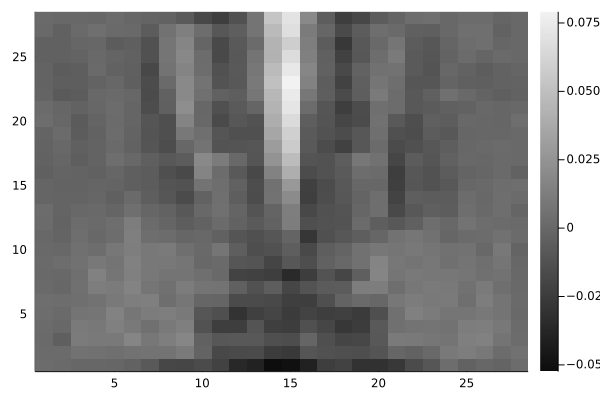

In [51]:
heatmap(transpose(reshape((explm.+explv),(28,28))),c=:grays,fmt=:png)

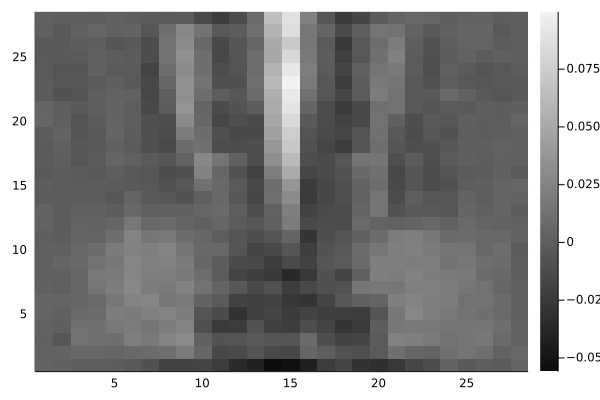

In [52]:
heatmap(transpose(reshape((explm_igs.+explv_igs),(28,28))),c=:grays,fmt=:png)

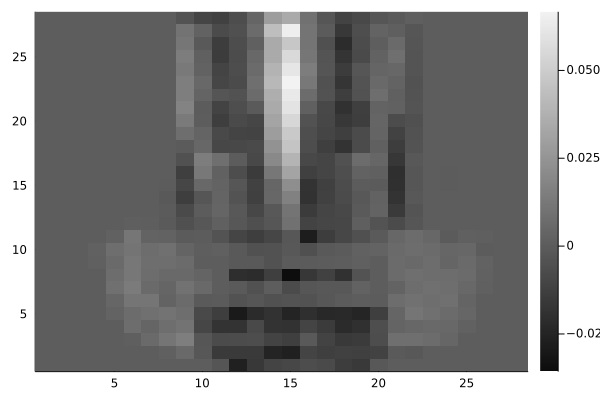

In [53]:
heatmap(transpose(reshape((explm.+explv).*xtrainS[:,n],(28,28))),c=:grays,fmt=:png)

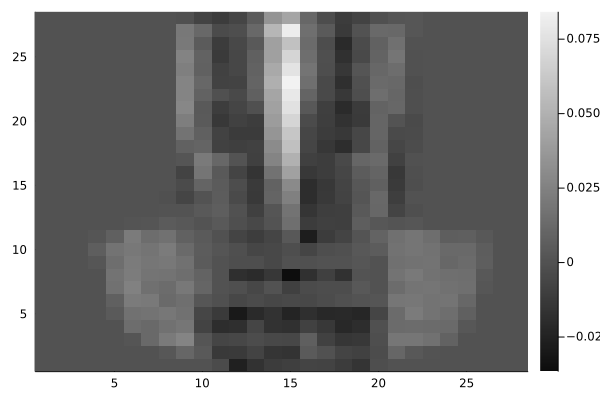

In [54]:
heatmap(transpose(reshape((explm_igs.+explv_igs).*xtrainS[:,n],(28,28))),c=:grays,fmt=:png)

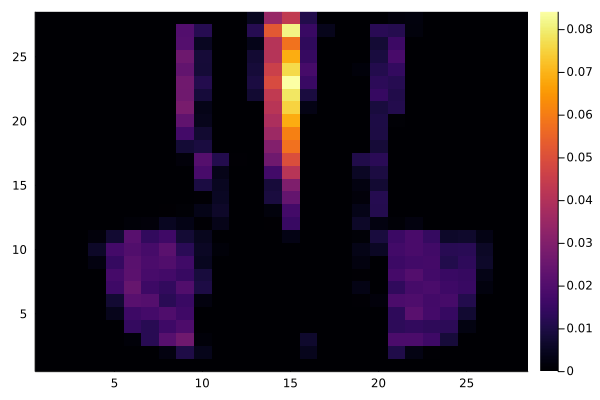

In [55]:
expl = (explm_igs.+explv_igs).*xtrainS[:,n]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png)

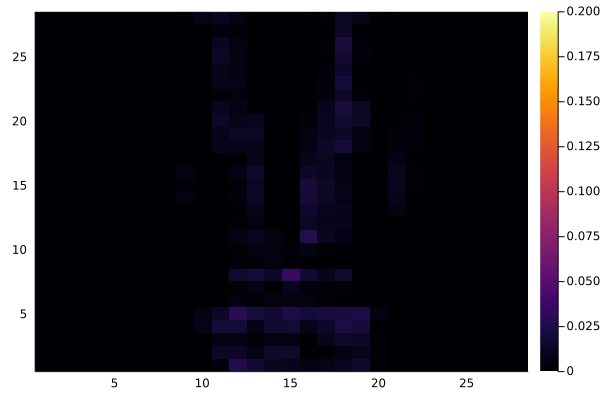

In [56]:
C = argmin(ytrainS[:,n])

outs = [dofuns(test2,xtrainS[:,n:n],m,C,i) for i in 1:784]

explm = map(x->x[1],outs)
explv = map(x->0.5*sum(x[2][1].*v),outs)




outs_ig = [[dofuns(test2,xtrainS[:,n:n].*alpha./10,m,C,i) for i in 1:784] for alpha in 1:10]

explm_ig = map(out_ig->map(x->x[1],out_ig),outs_ig)
explv_ig = map(out_ig->map(x->0.5*sum(x[2][1].*v),out_ig),outs_ig)

explm_igs = mean(hcat(explm_ig...),dims=2)
explv_igs = mean(hcat(explv_ig...),dims=2)

expl = (explm_igs.+explv_igs).*xtrainS[:,n]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png,clim=(0,0.2))

In [57]:
n = 9
C = argmax(ytrainS[:,n])

m = [test2.SVGPG[c](xtrainS[:,n:n]).μ[1] for c in 1:2]
v = [test2.SVGPG[c](xtrainS[:,n:n]).Σ[1] for c in 1:2]


function dofuns(mmm,X,M,c,i)
    tfun = targFun(test2, X,c,i)
    explm = tfun(M)
    H = Zygote.diaghessian(a->tfun(a),M)
    
    return explm, H
end

outs = [dofuns(test2,xtrainS[:,n:n],m,C,i) for i in 1:784]

explm = map(x->x[1],outs)
explv = map(x->0.5*sum(x[2][1].*v),outs)




outs_ig = [[dofuns(test2,xtrainS[:,n:n].*alpha./10,m,C,i) for i in 1:784] for alpha in 1:10]

explm_ig = map(out_ig->map(x->x[1],out_ig),outs_ig)
explv_ig = map(out_ig->map(x->0.5*sum(x[2][1].*v),out_ig),outs_ig)

explm_igs = mean(hcat(explm_ig...),dims=2)
explv_igs = mean(hcat(explv_ig...),dims=2)

784×1 Matrix{Float64}:
  0.0009225601087911036
  0.00048448950252191097
  0.0001260470653229655
  0.0004713594949583847
  0.00037916212794895574
 -0.00018048711559948624
 -0.0001629351834213191
 -0.0014573316064291782
 -0.0018759172604215328
 -0.0016548335912372307
 -0.0014676057811893969
 -0.0018080644451782947
 -0.0019375757222149458
  ⋮
  0.009846427058603497
  0.009488400724929536
  0.007237138877912492
  0.006600556407698875
  0.004960067695298967
  0.003811903231519348
  0.002826489935944951
  0.0012321730520271476
  0.0010215404603138327
  0.0008310882128299247
  0.0006693242724756367
 -1.261365975690206e-5

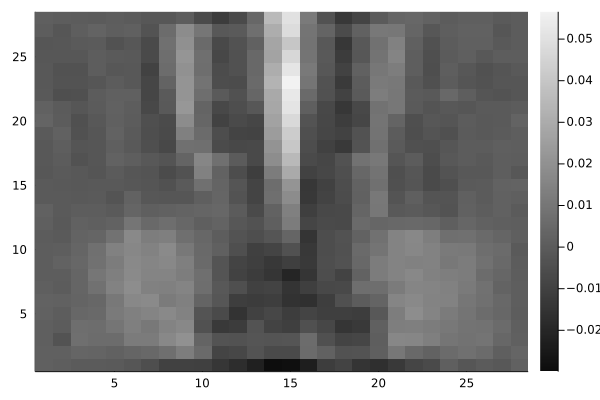

In [58]:
heatmap(transpose(reshape((explm.+explv),(28,28))),c=:grays,fmt=:png)

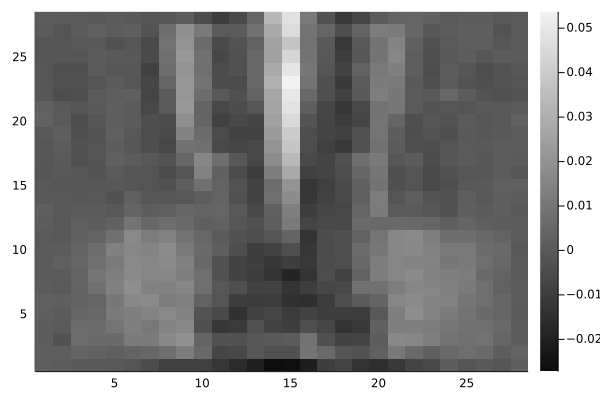

In [59]:
heatmap(transpose(reshape((explm_igs.+explv_igs),(28,28))),c=:grays,fmt=:png)

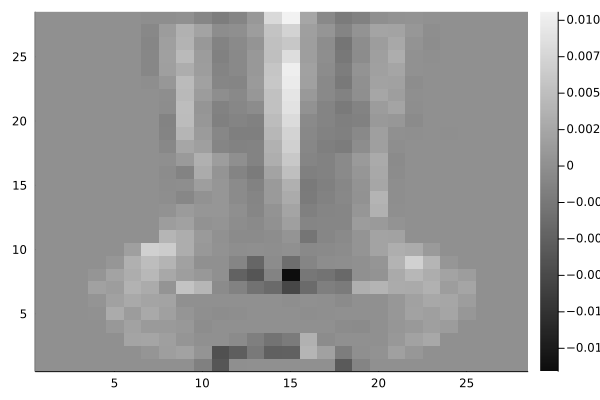

In [60]:
heatmap(transpose(reshape((explm.+explv).*xtrainS[:,n],(28,28))),c=:grays,fmt=:png)

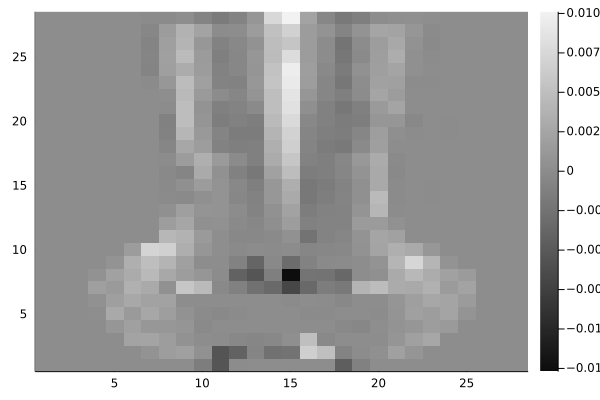

In [61]:
heatmap(transpose(reshape((explm_igs.+explv_igs).*xtrainS[:,n],(28,28))),c=:grays,fmt=:png)

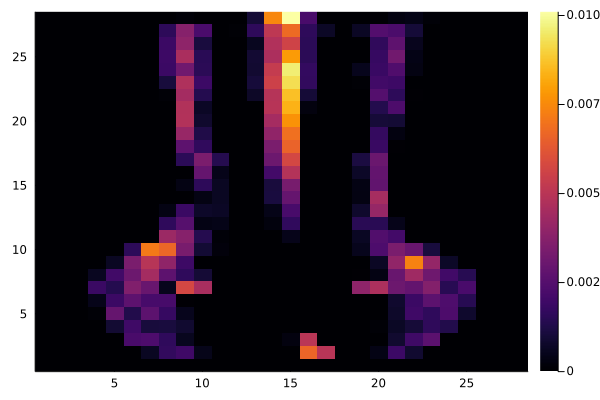

In [62]:
expl = (explm_igs.+explv_igs).*xtrainS[:,n]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png)

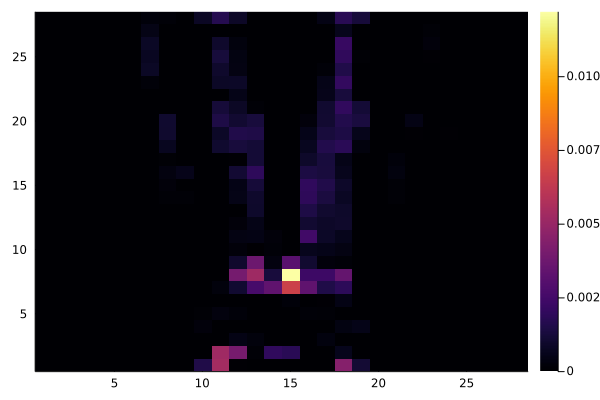

In [63]:
C = argmin(ytrainS[:,n])

outs = [dofuns(test2,xtrainS[:,n:n],m,C,i) for i in 1:784]

explm = map(x->x[1],outs)
explv = map(x->0.5*sum(x[2][1].*v),outs)




outs_ig = [[dofuns(test2,xtrainS[:,n:n].*alpha./10,m,C,i) for i in 1:784] for alpha in 1:10]

explm_ig = map(out_ig->map(x->x[1],out_ig),outs_ig)
explv_ig = map(out_ig->map(x->0.5*sum(x[2][1].*v),out_ig),outs_ig)

explm_igs = mean(hcat(explm_ig...),dims=2)
explv_igs = mean(hcat(explv_ig...),dims=2)

expl = (explm_igs.+explv_igs).*xtrainS[:,n]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png)

In [64]:
n = 2
C = argmax(ytrainS[:,n])

m = [test2.SVGPG[c](xtrainS[:,n:n]).μ[1] for c in 1:2]
v = [test2.SVGPG[c](xtrainS[:,n:n]).Σ[1] for c in 1:2]


function dofuns(mmm,X,M,c,i)
    tfun = targFun(test2, X,c,i)
    explm = tfun(M)
    H = Zygote.diaghessian(a->tfun(a),M)
    
    return explm, H
end

outs = [dofuns(test2,xtrainS[:,n:n],m,C,i) for i in 1:784]

explm = map(x->x[1],outs)
explv = map(x->0.5*sum(x[2][1].*v),outs)




outs_ig = [[dofuns(test2,xtrainS[:,n:n].*alpha./10,m,C,i) for i in 1:784] for alpha in 1:10]

explm_ig = map(out_ig->map(x->x[1],out_ig),outs_ig)
explv_ig = map(out_ig->map(x->0.5*sum(x[2][1].*v),out_ig),outs_ig)

explm_igs = mean(hcat(explm_ig...),dims=2)
explv_igs = mean(hcat(explv_ig...),dims=2)

784×1 Matrix{Float64}:
 -0.001735737489627065
 -0.000997367519490591
  0.0008000917957246521
  0.0019989113895638464
  0.002527378576173421
  0.004803413126875889
  0.011338885258325018
  0.02006353527663394
  0.019648783750885652
  0.01991899165637693
  0.028847584896976686
  0.03887503808097035
  0.04957963126142116
  ⋮
  0.02373742732395078
  0.04506447676881291
  0.03087785057631215
  0.010740958451515781
 -0.00040943511563551656
 -0.003567373535944356
 -0.001048346865357213
  0.001958896288003046
 -0.0005234627546232757
 -0.0012555107322618467
  0.00310761487707628
  0.0001674642454630712

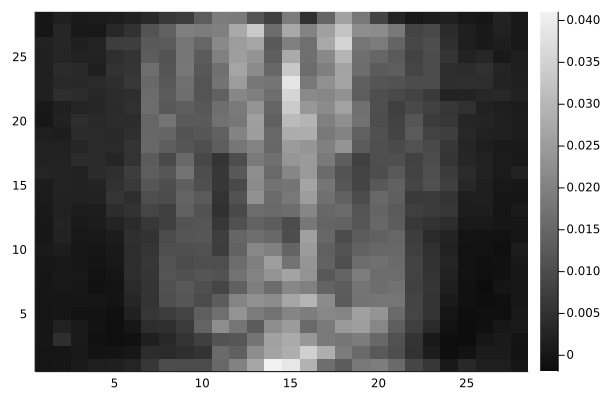

In [65]:
heatmap(transpose(reshape((explm.+explv),(28,28))),c=:grays,fmt=:png)

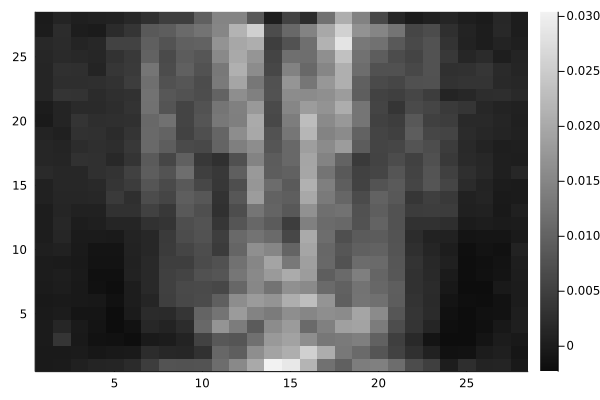

In [66]:
heatmap(transpose(reshape((explm_igs.+explv_igs),(28,28))),c=:grays,fmt=:png)

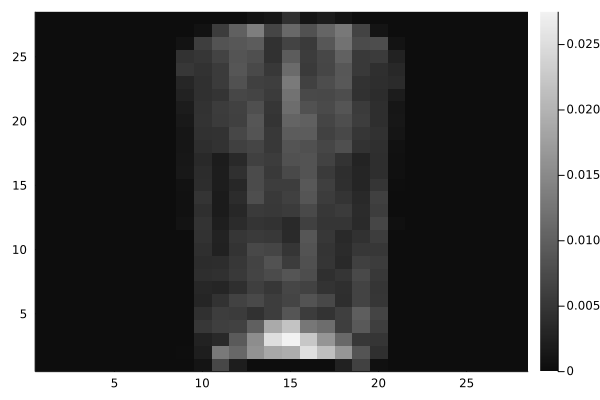

In [67]:
heatmap(transpose(reshape((explm.+explv).*xtrainS[:,n],(28,28))),c=:grays,fmt=:png)

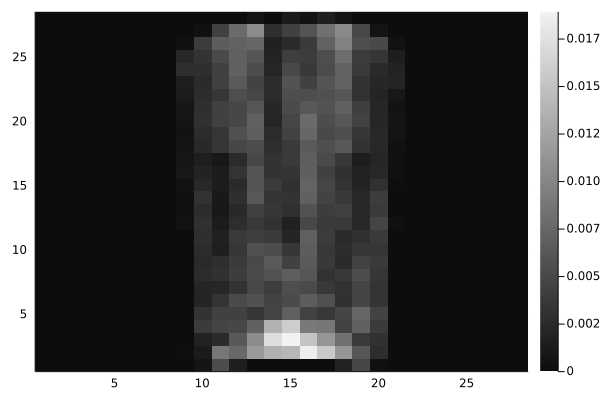

In [68]:
heatmap(transpose(reshape((explm_igs.+explv_igs).*xtrainS[:,n],(28,28))),c=:grays,fmt=:png)

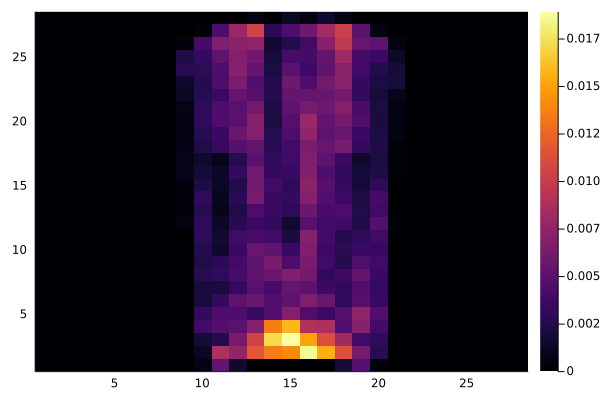

In [69]:
expl = (explm_igs.+explv_igs).*xtrainS[:,n]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png)

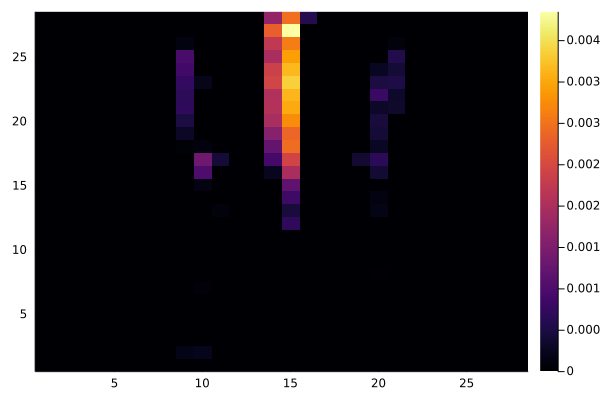

In [70]:
C = argmin(ytrainS[:,n])

outs = [dofuns(test2,xtrainS[:,n:n],m,C,i) for i in 1:784]

explm = map(x->x[1],outs)
explv = map(x->0.5*sum(x[2][1].*v),outs)




outs_ig = [[dofuns(test2,xtrainS[:,n:n].*alpha./10,m,C,i) for i in 1:784] for alpha in 1:10]

explm_ig = map(out_ig->map(x->x[1],out_ig),outs_ig)
explv_ig = map(out_ig->map(x->0.5*sum(x[2][1].*v),out_ig),outs_ig)

explm_igs = mean(hcat(explm_ig...),dims=2)
explv_igs = mean(hcat(explv_ig...),dims=2)

expl = (explm_igs.+explv_igs).*xtrainS[:,n]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png)

In [71]:
n = 3
C = argmax(ytrainS[:,n])

m = [test2.SVGPG[c](xtrainS[:,n:n]).μ[1] for c in 1:2]
v = [test2.SVGPG[c](xtrainS[:,n:n]).Σ[1] for c in 1:2]


function dofuns(mmm,X,M,c,i)
    tfun = targFun(test2, X,c,i)
    explm = tfun(M)
    H = Zygote.diaghessian(a->tfun(a),M)
    
    return explm, H
end

outs = [dofuns(test2,xtrainS[:,n:n],m,C,i) for i in 1:784]

explm = map(x->x[1],outs)
explv = map(x->0.5*sum(x[2][1].*v),outs)




outs_ig = [[dofuns(test2,xtrainS[:,n:n].*alpha./10,m,C,i) for i in 1:784] for alpha in 1:10]

explm_ig = map(out_ig->map(x->x[1],out_ig),outs_ig)
explv_ig = map(out_ig->map(x->0.5*sum(x[2][1].*v),out_ig),outs_ig)

explm_igs = mean(hcat(explm_ig...),dims=2)
explv_igs = mean(hcat(explv_ig...),dims=2)

784×1 Matrix{Float64}:
 -0.006027664538930819
 -0.003233985764983163
  0.002477039214342571
  0.005255082012449992
  0.0070847914292983625
  0.014851336769907237
  0.03444050139851603
  0.06513255950064936
  0.06623436062707738
  0.0650198070750194
  0.09081031706332744
  0.12445258837418553
  0.1561855133375581
  ⋮
  0.05320644919957631
  0.11953302531056556
  0.08547542398954919
  0.02768636761052713
 -0.005988998043314354
 -0.015172443629479577
 -0.006716136082401053
  0.004232611946343864
 -0.00332093664798949
 -0.0050256034096239355
  0.009251632232189206
  0.0007060302289513008

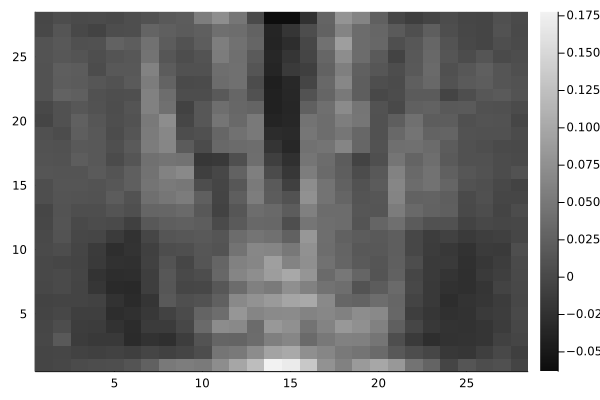

In [72]:
heatmap(transpose(reshape((explm.+explv),(28,28))),c=:grays,fmt=:png)

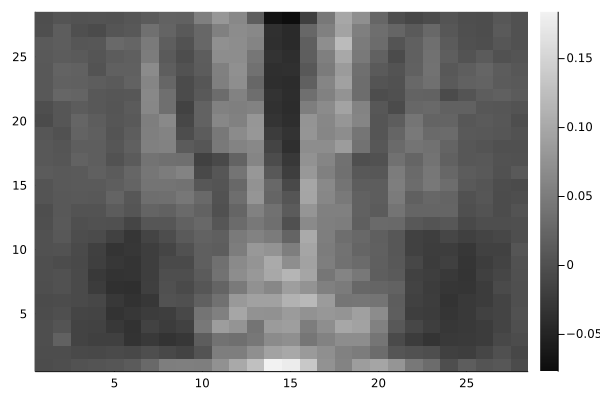

In [73]:
heatmap(transpose(reshape((explm_igs.+explv_igs),(28,28))),c=:grays,fmt=:png)

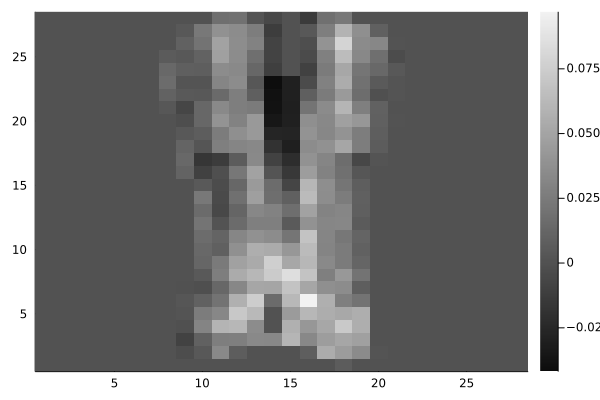

In [74]:
heatmap(transpose(reshape((explm.+explv).*xtrainS[:,n],(28,28))),c=:grays,fmt=:png)

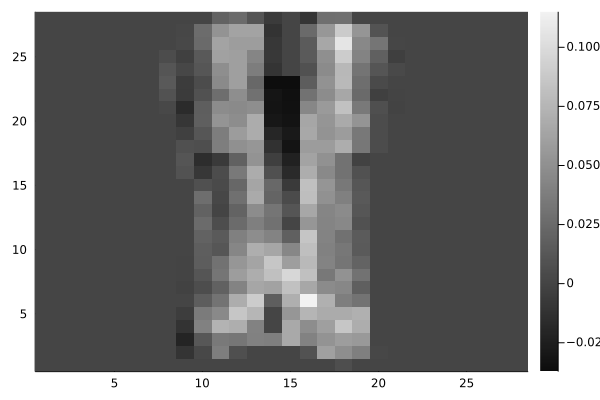

In [75]:
heatmap(transpose(reshape((explm_igs.+explv_igs).*xtrainS[:,n],(28,28))),c=:grays,fmt=:png)

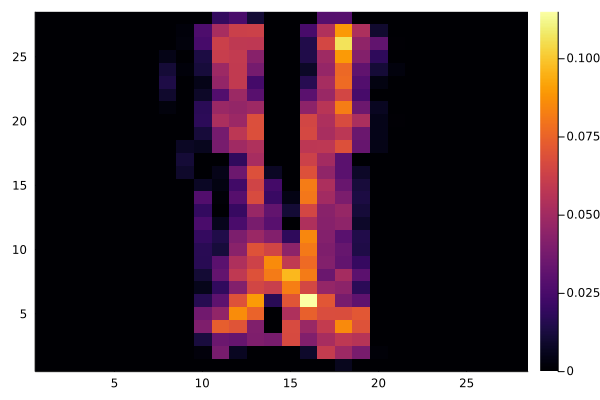

In [76]:
expl = (explm_igs.+explv_igs).*xtrainS[:,n]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png)

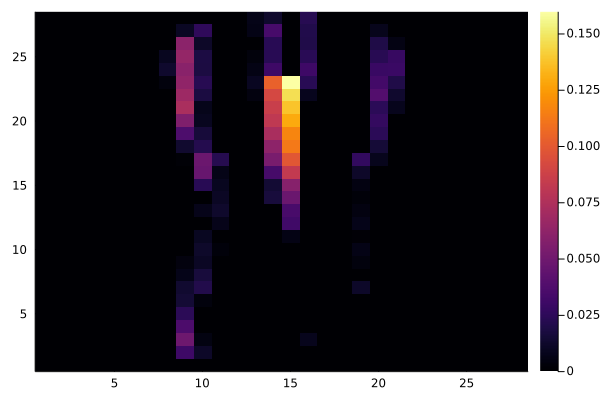

In [77]:
C = argmin(ytrainS[:,n])

outs = [dofuns(test2,xtrainS[:,n:n],m,C,i) for i in 1:784]

explm = map(x->x[1],outs)
explv = map(x->0.5*sum(x[2][1].*v),outs)




outs_ig = [[dofuns(test2,xtrainS[:,n:n].*alpha./10,m,C,i) for i in 1:784] for alpha in 1:10]

explm_ig = map(out_ig->map(x->x[1],out_ig),outs_ig)
explv_ig = map(out_ig->map(x->0.5*sum(x[2][1].*v),out_ig),outs_ig)

explm_igs = mean(hcat(explm_ig...),dims=2)
explv_igs = mean(hcat(explv_ig...),dims=2)

expl = (explm_igs.+explv_igs).*xtrainS[:,n]
expl[expl.<=0] .= 0.
heatmap(transpose(reshape(expl,(28,28))),fmt=:png)